# Estimation of producible energy using the RESOURCECODE Toolbox

This notebook shows how the toolbox can be used to estimate the energy producible by a classical WEC device on anypoint of the covered area.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import resourcecode
from resourcecode import producible_assessment
from resourcecode.spectrum import compute_jonswap_wave_spectrum

### Load WEC characteristics: PTO, capture width and corresponding frequencies

Default characteristics are provided with the package, but the user is free to change it to use a specific device.

In [2]:
DATA_DIR = Path(producible_assessment.__file__).parent / "Inputs"
capture_width = pd.read_csv(DATA_DIR / "capture_width.csv", delimiter=",", header=None)
freq =pd.read_csv( DATA_DIR / "Frequencies.csv", delimiter=",", header=None)
pto_data = pd.read_csv(DATA_DIR / "PTO_values.csv", delimiter=",", header=None)
capture_width.columns = pto_data.values.tolist()[0]
capture_width.index = [val for sublist in freq.values.tolist() for val in sublist]

### Plot of the characteristics

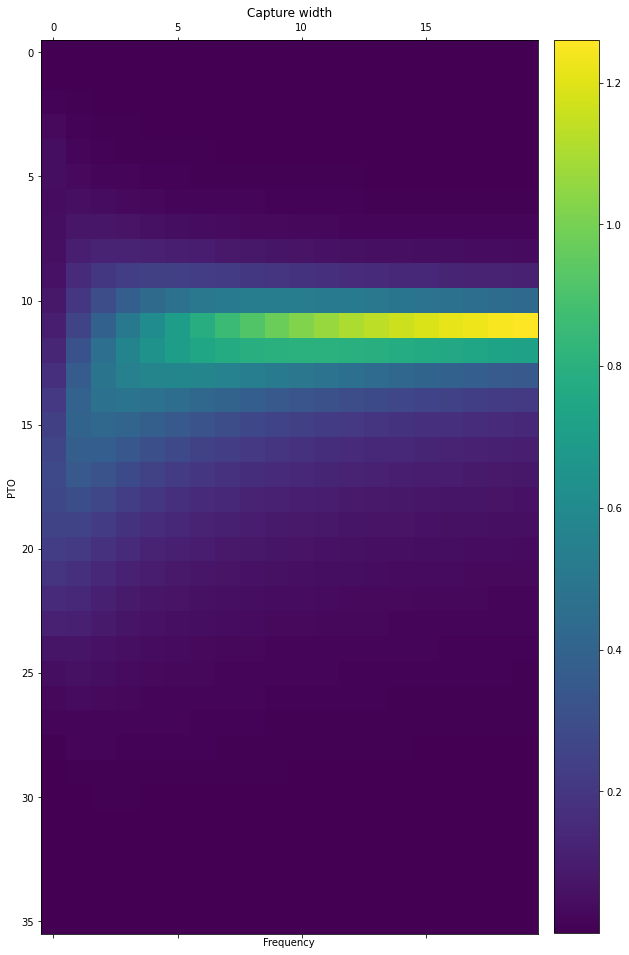

In [3]:
fig, ax = plt.subplots(1,1,figsize=(10,20))
plt.xlabel('Frequency')
plt.ylabel('PTO')
img = ax.matshow(capture_width.to_numpy())
fig.colorbar(img,fraction=0.08, pad=0.03)
plt.title('Capture width');

We also extracted the time series of 1D wave spectra from the RESOURCECODE database. At some point, this data will also by directly acessible, but for now it has to be precessed. For this example, we used the data from the SEMREVO location.

In [4]:
stations=resourcecode.data.get_grid_spec()
stations[stations["name"]=="SEMREVO"]
spec_data = pd.read_feather('1D_spectra_SEMREVO_201402.feather')
spec_data = spec_data.drop(columns='time')

The 1D wave spectrum can also be approximated using a JONSWAP spectrum with the sea-state parameters extracted from the database.

In [5]:
client = resourcecode.Client()
wave_data = client.get_dataframe_from_url("https://resourcecode.ifremer.fr/explore?pointId=119947&startDateTime=2014-02-01T00%3A00%3A00.000Z&endDateTime=2014-02-28T23%3A00%3A00.000Z", parameters=("hs", "tp"))

freq_vec = capture_width.index
spectrum = compute_jonswap_wave_spectrum(wave_data, freq_vec)

In [6]:
spec_data.columns = spectrum.columns

pto_jonswap = producible_assessment.PTO(capture_width, spectrum)
pto = producible_assessment.PTO(capture_width, spec_data)

d:\Projets\2020-RESOURCECODE\gitlab_IFR\env-resourcecode\lib\site-packages\resourcecode\producible_assessment\main.py:137: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ((c_g * s)[:, np.newaxis] * self.capture_width).T,


In [7]:
def plot_time_series(pto):
    """Plot PTO results time series in 3 subplots: wave power, absorbed/mean power
    with/without reduction factor, PTO damping with/without reduction factor.
    Power is converted from W to kW, damping from Ns/m to kNs/m.

    :param pto: PTO object
    :type pto: PTO"""
    # wave power
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    ax1.plot(pto.wave_power.div(1000 * pto.width))
    ax1.legend(["Wave power"])
    ax1.grid()
    ax1.set(xlabel="Time", ylabel="Power (kW/m)")
    # absorbed/mean power
    all_time_series = [
        pto.power,
        pto.power_no_red,
        pto.mean_power,
        pto.mean_power_no_red,
    ]
    linestyles = ["solid", "dashed", "solid", "dashed"]
    for time_series, linestyle in zip(all_time_series, linestyles):
        ax2.plot(time_series.div(1000), linestyle=linestyle)
    ax2.legend(
        [
            "Absorbed power (with reduction factor)",
            "Absorbed power (without reduction factor)",
            "Mean power (with reduction factor)",
            "Mean power (without reduction factor)",
        ]
    )
    ax2.grid()
    ax2.set(xlabel="Time", ylabel="Power (kW)")
    # PTO damping
    all_time_series = [pto.pto_damp, pto.pto_damp_no_red]
    for time_series, linestyle in zip(all_time_series, linestyles):
        ax3.plot(time_series.div(1000), linestyle=linestyle)
    ax3.legend(
        [
            "PTO damping (with reduction factor)",
            "PTO damping (without reduction factor)",
        ]
    )
    ax3.grid()
    ax3.set(xlabel="Time", ylabel="Damping (kN.s/m)")

def plot_cumulative_power(pto):
    """Plot PTO cumulative power. Power is converted from W to kW

    :param pto: PTO object
    :type pto: PTO"""

    # absorbed power

    power_kw = pto.power.div(1000)
    # cumulative power
    cumulative_power_kw = pto.cumulative_power
    power_ordered = pto.power.sort_values(by=0)
    index = [x / 1000 for x in power_ordered[0]]
    cumulative_power_kw.index = index
    # mean power
    mean_power_kw = pto.mean_power[0][pto.times[0]] / 1000
    # median power
    median_power_kw = pto.median_power[0][pto.times[0]] / 1000
    # power occurrences, cumulative power, mean and median power
    ax = power_kw.plot.hist(
        bins=len(pto.capture_width.columns) * 5,
        legend=False,
        weights=np.ones_like(power_kw[power_kw.columns[0]]) * 100.0 / len(power_kw),
    )
    ax1 = ax.twinx()
    cumulative_power_kw.plot(ax=ax1, legend=False, color="r")
    ax.grid()
    ax.set_xlabel("WEC Power (kW)")
    ax.set_ylabel("Occurrence (%)")
    ax1.set_ylabel("Normed Cumulative Production (%)")
    line_mean = plt.axvline(x=mean_power_kw, color="y")
    line_median = plt.axvline(x=median_power_kw, color="orange")
    ax.legend([line_mean, line_median], ["Mean power", "Median power"])

    # plot PTO histogram
    pto_damp_kn = pto.pto_damp / 1000
    ax = pto_damp_kn.plot.hist(
        bins=len(pto.capture_width.columns),
        legend=False,
        weights=np.ones_like(pto_damp_kn[pto_damp_kn.columns[0]])
        * 100.0
        / len(pto_damp_kn),
    )
    ax.grid()
    ax.set_xlabel("PTO damping (kN.s/m)")
    ax.set_ylabel("Occurrence (%)")

The functions defined above helps to vizualize the output from the `producible_assessment.PTO` function. The first graph is an estimation of the wave power, the second one represented the absorded energy (with and without some reduction factor), while the last plot contains the PTO damping time series.
The graphs are shown for the PTO obtained from the real 1D spectra and for the JONSWAP computed from the integral sea-state parameters $H_s$ and $T_p$.

In [8]:
plot_time_series(pto)
plot_time_series(pto_jonswap)

In [9]:
plot_cumulative_power(pto)
plot_cumulative_power(pto_jonswap)